In [2]:
from hmmlearn import hmm
import pandas as pd
import os
import numpy as np
import pickle

In [3]:
def get_sequence(filename, X, lengths):
    file = pd.read_csv(filename)
    for i, row in file.iterrows():
        X.append(list(row[4:]))
    lengths.append(len(file))
    return X, lengths

In [81]:
def findBestHMM(filename):
    logProbMax = 0
    modelBest = None
    PBest = None
    for i in range(10):
        try:
            model, mus, sigmas, P, logProb, convergence = fitHMM(X, lengths)
            if logProb > logProbMax and convergence.converged == True: #wrong do not use -> all not just highest score
                logProbMax = logProb
                modelBest = model
                PBest = P 
        except:
            continue
    with open(filename + ".pkl", "wb") as file: pickle.dump(modelBest, file)
    return modelBest, logProbMax, PBest

In [141]:
def fitHMM(X, lengths):
    # fit Gaussian HMM to Q
    model = hmm.GaussianHMM(n_components=3, n_iter=1000, init_params="cm")
    
    model.startprob_ = np.array([0.0, 1.0, 0.0]) # same initial state
    model.transmat_ = np.array([[0.8, 0.2, 0.0], # initial prob matrix, important is 0 in (1,3) (3,1) (3,2)
                                [0.05, 0.8, 0.15],
                                [0.0, 0.0, 1.0]])
     
    model.fit(X, lengths)
    # classify each observation as state 0 or 1
    #hidden_states = model.predict(X)
 
    # find parameters of Gaussian HMM
    convergence = model.monitor_
    mus = np.array(model.means_)
    sigmas = np.array(np.sqrt(np.array([np.diag(model.covars_[0]),np.diag(model.covars_[1])])))
    P = np.array(model.transmat_)
 
    # find log-likelihood of Gaussian HMM
    logProb = model.score(X, lengths)
 
    return model, mus, sigmas, P, logProb, convergence #hidden_states

In [154]:
#for directory in ["None", "right hand", "single note", "slower", "split hands", "both hands"]:
directory = "single note"
lengths = []
X = []
for filename in os.listdir(directory):
    X, lengths = get_sequence(directory + "/" + filename, X, lengths)
model, mus, sigmas, P, logProb, convergence = fitHMM(X, lengths) #directory equals practice mode
#model, logProb, P = findBestHMM(directory)
print("/n", directory)
print("P", P)
print("logProb", logProb)
#print("means", mus)
print("convergences", convergence)
print("")
#with open("testmodel.pkl", "wb") as file: pickle.dump(model, file)

/n single note
P [[1.00000000e+00 4.09542409e-32 0.00000000e+00]
 [1.66666666e-01 8.20512821e-01 1.28205128e-02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
logProb 6731.9710201843145
convergences ConvergenceMonitor(
    history=[1955.105902295426, 6185.09824157095, 6731.971019215117, 6731.971020184315],
    iter=4,
    n_iter=1000,
    tol=0.01,
    verbose=False,
)



In [334]:
with open("identity5.pkl", "wb") as file: pickle.dump(model, file)
    
#Note: both hands combined for three states, makes no sense.

In [25]:
directory = "left hand"
with open("BestThreeStates/" + directory + "/" + directory + "4.pkl", "rb") as file:
            model = pickle.load(file)
print("Transition matrix")
print(model.transmat_)

#print("Model means")
#print(model.means_)
mus = model.means_

state0 = mus[0][5] + mus[0][11]
state1 = mus[1][5] + mus[1][11]
state2 = mus[2][5] + mus[2][11]

print([state0, state1, state2])

max_error = np.argmax([state0, state1, state2])
min_error = np.argmin([state0, state1, state2])

new_max, new_min = new_error_comp(mus)

print("state with min_error:", min_error)
print("state with max error:", max_error)

print("state with new min_error:", new_min)
print("state with new max error:", new_max)
#means
#covariance
#transition
indizes = []

"""
if new_min != 2:
    if new_min == 0:
        indizes = [2,1,0]
        model.transmat_ = swap_row(swap_column(model.transmat_, indizes), indizes)
        model.means_ = swap_row(model.means_, indizes)
    elif new_min == 1:
        print("Wow, hier läuft was schief! Das Model sollte raus")
"""
indizes = [2,1,0]
model.transmat_ = swap_row(swap_column(model.transmat_, indizes), indizes)
model.means_ = swap_row(model.means_, indizes)

print("Transition matrix after")
print(model.transmat_)

        
with open("left hand4_new.pkl", "wb") as file: pickle.dump(model, file)


Transition matrix
[[7.52262820e-33 1.00000000e+00 0.00000000e+00]
 [1.87501749e-01 7.49995673e-01 6.25025781e-02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[1.9520265746498267, 1.0598242347352753, 1.1825672926018316]
min 3 -2 -1
state with min_error: 1
state with max error: 0
state with new min_error: 1
state with new max error: 0
Transition matrix after
[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.25025781e-02 7.49995673e-01 1.87501749e-01]
 [0.00000000e+00 1.00000000e+00 7.52262820e-33]]


In [12]:
def new_error_comp(mus):
    state0 = state1 = state2 = 0
    for i in range(len(mus[0])):
        emax = np.argmax([mus[0][i], mus[1][i], mus[2][i]])
        emin = np.argmin([mus[0][i], mus[1][i], mus[2][i]])
        if emax == 0:
            state0 += 1
        elif emax == 1:
            state1 += 1
        elif emax == 2:
            state2 += 1
        if emin == 0:
            state0 -= 1
        elif emin == 1:
            state1 -= 1
        elif emin == 2:
            state2 -= 1
    new_max = np.argmax([state0, state1, state2])
    new_min = np.argmin([state0, state1, state2])
    print("min", state0, state1, state2)
    return new_max, new_min

In [6]:
def swap_column(arr, indizes):
    arr[:, [0,1,2]] = arr[:, indizes]
    return arr

In [7]:
def swap_row(arr, indizes):
    arr[[0,1,2]] = arr[indizes]
    return arr

In [ ]:
"""
if new_min == 0 and new_max == 2:
    # 0 -> 2, 2-> 0
    indizes = [2,1,0]
elif new_min == 0 and new_max == 1:
    # 0 -> 2, 1-> 0, 2 -> 1
    indizes = [2,0,1]
elif new_min == 1 and new_max == 2:
    # 0 -> 1, 1 -> 2, 2 -> 0
    indizes = [1,2,0]
elif new_min == 1 and new_max == 0:
    # 1 -> 2, 2 -> 1
    indizes = [0,2,1]
elif new_min == 2 and new_max == 1:
    # 1 -> 0, 0 -> 1
    indizes = [1,0,2]
else:
    indizes = [0,1,2]
model.transmat_ = swap_row(swap_column(model.transmat_, indizes), indizes)
model.means_ = swap_row(model.means_, indizes)
#model.covars_ = swap_row(model.covars_, indizes)

print(model.transmat_)
#wit

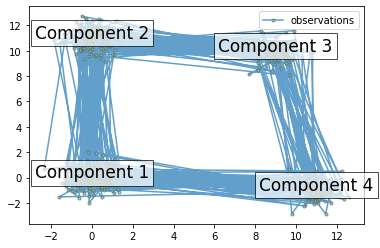

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn import hmm

# Prepare parameters for a 4-components HMM
# Initial population probability
startprob = np.array([0.6, 0.3, 0.1, 0.0])
# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat = np.array([[0.7, 0.2, 0.0, 0.1],
                     [0.3, 0.5, 0.2, 0.0],
                     [0.0, 0.3, 0.5, 0.2],
                     [0.2, 0.0, 0.2, 0.6]])
# The means of each component
means = np.array([[0.0,  0.0],
                  [0.0, 11.0],
                  [9.0, 10.0],
                  [11.0, -1.0]])
# The covariance of each component
covars = .5 * np.tile(np.identity(2), (4, 1, 1))

# Build an HMM instance and set parameters
model = hmm.GaussianHMM(n_components=4, covariance_type="full")

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars

# Generate samples
X, Z = model.sample(500)

# Plot the sampled data
plt.plot(X[:, 0], X[:, 1], ".-", label="observations", ms=6,
         mfc="orange", alpha=0.7)

# Indicate the component numbers
for i, m in enumerate(means):
    plt.text(m[0], m[1], 'Component %i' % (i + 1),
             size=17, horizontalalignment='center',
             bbox=dict(alpha=.7, facecolor='w'))
plt.legend(loc='best')
plt.show()